In [ ]:
# Preprocesamiento conservando la etiqueta 'segmento' intacta
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv(r"C:\Users\FABIO\Downloads\dataset_hoteles_tunja_50000_segmentado.csv",
                 encoding="utf-8-sig")

df_pre = df.copy()

target_col = "segmento"  # <-- tu etiqueta con clases: económico / precio-calidad / premium

# Identificar categóricas/booleanas y EXCLUIR la etiqueta
cat_cols = df_pre.select_dtypes(include=["object", "bool"]).columns.tolist()
cat_cols = [c for c in cat_cols if c != target_col]

print("Cat/Bool a codificar (sin la etiqueta):", cat_cols)

le = LabelEncoder()
for col in cat_cols:
    if df_pre[col].nunique() == 2:
        df_pre[col] = le.fit_transform(df_pre[col])
    else:
        dummies = pd.get_dummies(df_pre[col], prefix=col)
        df_pre = pd.concat([df_pre.drop(col, axis=1), dummies], axis=1)

# Verificación
print("Tiene la etiqueta 'segmento'?", "segmento" in df_pre.columns)
print("Distribución de segmento:\n", df_pre["segmento"].value_counts())

# Guardar
df_pre.to_csv("dataset_hoteles_tunja_numerico.csv", index=False, encoding="utf-8-sig")
print("OK: dataset_hoteles_tunja_numerico.csv con 'segmento' intacta")





Cat/Bool a codificar (sin la etiqueta): ['Género', 'Procedencia', 'Tipo_viajero', 'Motivo_viaje', 'Temporada', 'Canal_reserva', 'Cancelación_probable', 'Ocupación', 'WiFi', 'Parqueadero', 'Spa_gimnasio', 'Restaurante', 'Desayuno_incluido', 'Sostenibilidad', 'PetFriendly', 'Fidelización', 'Reseña', 'Reputación_online', 'Atención_personal', 'Limpieza', 'nivel_servicios']
Tiene la etiqueta 'segmento'? True
Distribución de segmento:
 segmento
premium           17561
económico         16580
precio-calidad    15859
Name: count, dtype: int64
OK: dataset_hoteles_tunja_numerico.csv con 'segmento' intacta


In [8]:
# =========================================
# Pipeline completo: prepara dataset (si falta) + entrena ExtraTrees (Objetivo 3)
# =========================================
# Requisitos:
#   pip install scikit-learn pandas numpy joblib
# Entradas:
#   - RAW_PATH: CSV original con columna 'segmento'
#   - (opcional) dataset_hoteles_tunja_numerico_con_target.csv si ya lo tienes
# Salidas (carpeta ./modelo_obj3):
#   - extratrees_obj3_pipeline.joblib
#   - reporte_clasificacion_test.csv
#   - matriz_confusion_test.csv
#   - top25_importancias.csv
#   - metadata.json

import os, json, joblib, numpy as np, pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

# -----------------------------------------------------------
# 0) Configuración de rutas
# -----------------------------------------------------------
TARGET = "segmento"   # etiqueta con clases: económico / precio-calidad / premium
DATA_PATH = Path("dataset_hoteles_tunja_numerico_con_target.csv")  # objetivo
RAW_PATH  = Path(r"C:\Users\FABIO\Downloads\dataset_hoteles_tunja_50000_segmentado.csv")  # origen

TEST_SIZE = 0.20
RANDOM_STATE = 42
N_SPLITS_CV = 5
N_ITER_SEARCH = 40

OUT_DIR = Path("modelo_obj3"); OUT_DIR.mkdir(exist_ok=True)

print("Working directory:", Path.cwd())
print("¿Existe DATA_PATH?", DATA_PATH.exists())
print("¿Existe RAW_PATH?", RAW_PATH.exists())

# -----------------------------------------------------------
# 1) Función: asegurar dataset numérico con target intacto
# -----------------------------------------------------------
def ensure_numeric_with_target(data_path: Path, raw_path: Path, target_col: str) -> Path:
    """
    Si data_path existe, lo usa.
    Si no existe, intenta:
      A) construirlo desde un 'dataset_hoteles_tunja_numerico.csv' (reconstruyendo 'segmento' si quedó en dummies)
      B) generar desde RAW_PATH conservando 'segmento' sin one-hot
    """
    if data_path.exists():
        print(f"✔ Encontrado: {data_path}")
        return data_path

    # A) ¿Existe un numérico previo sin target unificado?
    num_prev = Path("dataset_hoteles_tunja_numerico.csv")
    if num_prev.exists():
        print(f"⚠ No se encontró {data_path.name}, pero sí {num_prev.name}. Intentando reconstruir etiqueta…")
        df = pd.read_csv(num_prev, encoding="utf-8-sig")

        # 1) Si ya está 'segmento' como columna única
        if target_col in df.columns:
            print("✔ 'segmento' ya está como columna única. Guardando dataset destino…")
            df.to_csv(data_path, index=False, encoding="utf-8-sig")
            return data_path

        # 2) Si quedó en dummies tipo 'segmento_*'
        label_dummy_cols = [c for c in df.columns if c.startswith(f"{target_col}_")]
        if label_dummy_cols:
            print("✔ Detección de dummies de la etiqueta. Reconstruyendo columna 'segmento'…")
            y_series = df[label_dummy_cols].idxmax(axis=1).str.replace(f"{target_col}_", "", regex=False)
            df[target_col] = y_series
            df = df.drop(columns=label_dummy_cols)
            df.to_csv(data_path, index=False, encoding="utf-8-sig")
            print(f"✔ Reconstruido y guardado: {data_path}")
            return data_path

        # 3) Si no hay forma de reconstruir, pasa a RAW
        print("⚠ No se detectaron dummies de la etiqueta en el numérico previo. Recurriendo a RAW_PATH…")

    # B) Generar desde RAW_PATH
    if not raw_path.exists():
        raise FileNotFoundError(
            f"No existe {data_path} ni {num_prev}. "
            f"Además, el RAW no se encontró en {raw_path}. Ajusta RAW_PATH o coloca el archivo en el working directory."
        )

    print(f"Construyendo {data_path.name} a partir de RAW_PATH…")
    df_raw = pd.read_csv(raw_path, encoding="utf-8-sig")

    if target_col not in df_raw.columns:
        raise ValueError(f"El archivo RAW no contiene la columna objetivo '{target_col}'.")

    df_pre = df_raw.copy()

    # Identificar categóricas/booleanas EXCLUYENDO la etiqueta
    cat_cols = df_pre.select_dtypes(include=["object", "bool"]).columns.tolist()
    cat_cols = [c for c in cat_cols if c != target_col]

    print("Categóricas/booleanas a codificar (sin la etiqueta):", len(cat_cols))

    # Codificación: binarias -> LabelEncoder, resto -> dummies
    le = LabelEncoder()
    for col in cat_cols:
        if df_pre[col].nunique() == 2:
            df_pre[col] = le.fit_transform(df_pre[col].astype(str))
        else:
            dummies = pd.get_dummies(df_pre[col], prefix=col)
            df_pre = pd.concat([df_pre.drop(col, axis=1), dummies], axis=1)

    # Guardar final con 'segmento' intacta
    df_pre.to_csv(data_path, index=False, encoding="utf-8-sig")
    print(f"✔ Dataset creado: {data_path}  (shape={df_pre.shape})")
    return data_path

# Asegurar que tenemos el dataset bueno
DATA_PATH = ensure_numeric_with_target(DATA_PATH, RAW_PATH, TARGET)

# -----------------------------------------------------------
# 2) Cargar dataset listo
# -----------------------------------------------------------
df = pd.read_csv(DATA_PATH, encoding="utf-8-sig")
if TARGET not in df.columns:
    # Intento final: si quedó en dummies, reconstruir
    label_dummy_cols = [c for c in df.columns if c.startswith(f"{TARGET}_")]
    if label_dummy_cols:
        y_series = df[label_dummy_cols].idxmax(axis=1).str.replace(f"{TARGET}_", "", regex=False)
        df[TARGET] = y_series
        df = df.drop(columns=label_dummy_cols)
    else:
        raise ValueError(f"No se encontró la columna objetivo '{TARGET}' en {DATA_PATH}.")

# -----------------------------------------------------------
# 3) Selección de variables (evitar IDs y posibles fugas)
# -----------------------------------------------------------
IGNORE_FIXED = {TARGET, "id", "id_cliente", "id_reserva", "index"}
LEAKAGE_PATTERNS = ("_target", "_label", "prob_", "score_", "pred_", "objetivo_", "es_")
IGNORE_LEAK = {c for c in df.columns if any(p in c.lower() for p in LEAKAGE_PATTERNS)}
IGNORE = set([c for c in df.columns if c.lower() in IGNORE_FIXED]) | IGNORE_LEAK

feature_cols = [c for c in df.columns if c not in IGNORE]
if not feature_cols:
    raise ValueError("No quedaron columnas de entrada tras aplicar IGNORE. Revisa exclusiones.")

X = df[feature_cols].copy()
y = df[TARGET].copy()

# Mapear y a códigos y conservar nombres de clase
if y.dtype == "O":
    y_cat = y.astype("category")
    class_names = list(y_cat.cat.categories)   # ['económico','precio-calidad','premium']
    y = y_cat.cat.codes                        # 0,1,2
else:
    class_names = sorted([str(c) for c in np.unique(y)])

print("Etiqueta:", TARGET)
print("Clases:", class_names)
print("Distribución de clases (total):")
print(pd.Series(y).value_counts(normalize=True).sort_index())

# -----------------------------------------------------------
# 4) Split estratificado
# -----------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# -----------------------------------------------------------
# 5) Detectar desbalance
# -----------------------------------------------------------
freq = pd.Series(y_train).value_counts(normalize=True)
imbalance = freq.min() < 0.35
class_weight_opt = "balanced" if imbalance else None
print(f"Desbalance detectado: {imbalance}. class_weight={class_weight_opt}")

# -----------------------------------------------------------
# 6) Pipeline: Imputación + ExtraTrees (baseline)
# -----------------------------------------------------------
baseline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", ExtraTreesClassifier(
        n_estimators=400,
        max_depth=None,
        max_features="sqrt",
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight=class_weight_opt,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

baseline.fit(X_train, y_train)

# -----------------------------------------------------------
# 7) Evaluación baseline (Test)
# -----------------------------------------------------------
y_pred = baseline.predict(X_test)
rep_dict = classification_report(y_test, y_pred, digits=4, output_dict=True)
rep_df = pd.DataFrame(rep_dict).T
cm = confusion_matrix(y_test, y_pred)

print("\n=== BASELINE: Reporte en Test ===")
print(rep_df)
print("Matriz de confusión (baseline):\n", cm)

# AUC binario o multiclase (OVR)
auc_baseline = None
try:
    model_step = baseline.named_steps["model"]
    if hasattr(model_step, "predict_proba"):
        y_prob = baseline.predict_proba(X_test)
        if len(np.unique(y)) == 2:
            auc_baseline = roc_auc_score(y_test, y_prob[:, 1])
        else:
            auc_baseline = roc_auc_score(y_test, y_prob, multi_class="ovr")
        print(f"AUC (baseline): {auc_baseline:.4f}")
except Exception as e:
    print("AUC (baseline) no calculado:", e)

# -----------------------------------------------------------
# 8) Validación cruzada (F1_macro)
# -----------------------------------------------------------
cv = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=RANDOM_STATE)
f1_cv = cross_val_score(baseline, X, y, cv=cv, scoring="f1_macro", n_jobs=-1)
print(f"\nCV F1_macro (baseline): mean={f1_cv.mean():.4f} ± {f1_cv.std():.4f}")

# -----------------------------------------------------------
# 9) Búsqueda aleatoria de hiperparámetros
# -----------------------------------------------------------
param_dist = {
    "model__n_estimators": [300, 400, 600, 800, 1000, 1200],
    "model__max_depth": [None, 10, 20, 30, 50],
    "model__max_features": ["sqrt", "log2", 0.3, 0.5, None],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 5, 10],
    "model__criterion": ["gini", "entropy"],
    "model__class_weight": [class_weight_opt] if class_weight_opt else [None, "balanced"]
}

search = RandomizedSearchCV(
    estimator=baseline,
    param_distributions=param_dist,
    n_iter=N_ITER_SEARCH,
    scoring="f1_macro",
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
search.fit(X_train, y_train)
best_model = search.best_estimator_
print("\n=== MEJORES HIPERPARÁMETROS ===")
print(search.best_params_)

# -----------------------------------------------------------
# 10) Evaluación del mejor modelo (Test)
# -----------------------------------------------------------
y_pred_best = best_model.predict(X_test)
rep_best_dict = classification_report(y_test, y_pred_best, digits=4, output_dict=True)
rep_best_df = pd.DataFrame(rep_best_dict).T
cm_best = confusion_matrix(y_test, y_pred_best)

print("\n=== MEJOR MODELO: Reporte en Test ===")
print(rep_best_df)
print("Matriz de confusión (best):\n", cm_best)

auc_best = None
try:
    model_final = best_model.named_steps["model"]
    if hasattr(model_final, "predict_proba"):
        y_prob_best = best_model.predict_proba(X_test)
        if len(np.unique(y)) == 2:
            auc_best = roc_auc_score(y_test, y_prob_best[:, 1])
        else:
            auc_best = roc_auc_score(y_test, y_prob_best, multi_class="ovr")
        print(f"AUC (best): {auc_best:.4f}")
except Exception as e:
    print("AUC (best) no calculado:", e)

# -----------------------------------------------------------
# 11) Importancias de variables (Top 25)
# -----------------------------------------------------------
importancias = pd.Series(model_final.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("\n=== TOP 25 FEATURES ===")
print(importancias.head(25))

# -----------------------------------------------------------
# 12) Guardar artefactos y métricas
# -----------------------------------------------------------
joblib.dump(best_model, OUT_DIR / "extratrees_obj3_pipeline.joblib")

rep_best_df.to_csv(OUT_DIR / "reporte_clasificacion_test.csv", encoding="utf-8-sig")
pd.DataFrame(cm_best).to_csv(OUT_DIR / "matriz_confusion_test.csv", index=False, encoding="utf-8-sig")

top25 = importancias.head(25).reset_index()
top25.columns = ["feature", "importance"]
top25.to_csv(OUT_DIR / "top25_importancias.csv", index=False, encoding="utf-8-sig")

meta = {
    "target": TARGET,
    "feature_names": feature_cols,
    "best_params": search.best_params_,
    "cv_f1_macro_mean": float(f1_cv.mean()),
    "cv_f1_macro_std": float(f1_cv.std()),
    "class_names": class_names,
    "auc_baseline": float(auc_baseline) if auc_baseline is not None else None,
    "auc_best": float(auc_best) if auc_best is not None else None,
    "random_state": RANDOM_STATE,
    "test_size": TEST_SIZE,
    "n_splits_cv": N_SPLITS_CV,
    "desbalance_detectado": bool(imbalance)
}
with open(OUT_DIR / "metadata.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print(f"\n✔ Modelo guardado en: {OUT_DIR/'extratrees_obj3_pipeline.joblib'}")
print(f"✔ Reporte de clasificación: {OUT_DIR/'reporte_clasificacion_test.csv'}")
print(f"✔ Matriz de confusión: {OUT_DIR/'matriz_confusion_test.csv'}")
print(f"✔ Top-25 importancias: {OUT_DIR/'top25_importancias.csv'}")
print(f"✔ Metadata: {OUT_DIR/'metadata.json'}")


Working directory: c:\Users\FABIO\Downloads\IAhotelera
¿Existe DATA_PATH? False
¿Existe RAW_PATH? True
⚠ No se encontró dataset_hoteles_tunja_numerico_con_target.csv, pero sí dataset_hoteles_tunja_numerico.csv. Intentando reconstruir etiqueta…
✔ 'segmento' ya está como columna única. Guardando dataset destino…
Etiqueta: segmento
Clases: ['económico', 'precio-calidad', 'premium']
Distribución de clases (total):
0    0.33160
1    0.31718
2    0.35122
Name: proportion, dtype: float64
Desbalance detectado: True. class_weight=balanced

=== BASELINE: Reporte en Test ===
              precision    recall  f1-score     support
0              0.993680  0.995778  0.994728   3316.0000
1              0.992738  0.991173  0.991955   3172.0000
2              0.998006  0.997437  0.997721   3512.0000
accuracy       0.994900  0.994900  0.994900      0.9949
macro avg      0.994808  0.994796  0.994801  10000.0000
weighted avg   0.994900  0.994900  0.994900  10000.0000
Matriz de confusión (baseline):
 [[33

✔ Guardado: figuras_obj3\pca_segmento_bonita.png
Varianza explicada PCA: PC1=0.297, PC2=0.163, Total=0.460


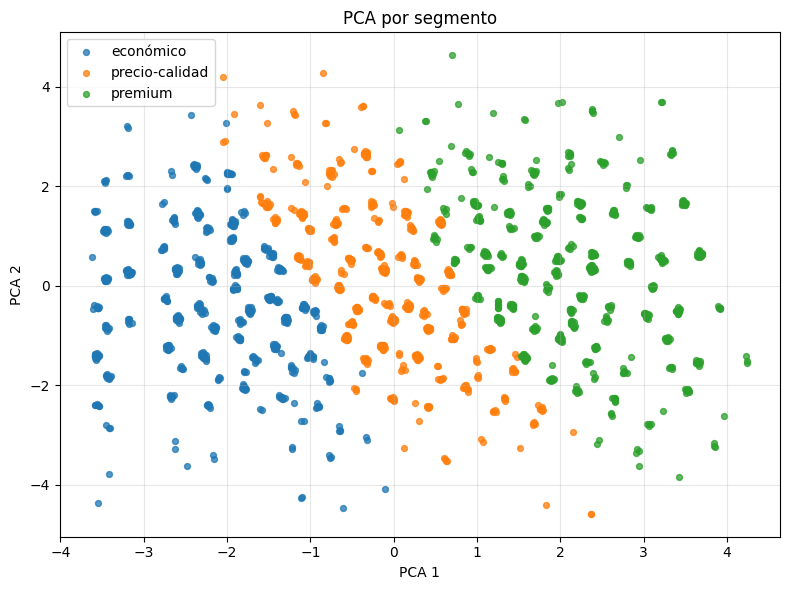

In [15]:
# =========================================
# Visualizaciones limpias del modelo entrenado (PCA y LDA)
# =========================================
# Requisitos: matplotlib, pandas, numpy, scikit-learn, joblib
import json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedShuffleSplit

# --- Rutas
MODEL_DIR = Path("modelo_obj3")
META_JSON = MODEL_DIR / "metadata.json"
TOP_CSV   = MODEL_DIR / "top25_importancias.csv"
FIG_DIR   = Path("figuras_obj3"); FIG_DIR.mkdir(exist_ok=True)

# Edita esta ruta si tu CSV original está en otro sitio
RAW_PATH  = Path(r"C:\Users\FABIO\Downloads\dataset_hoteles_tunja_50000_segmentado.csv")
NUM_PATH  = Path("dataset_hoteles_tunja_numerico_con_target.csv")

# --- Metadatos del modelo
meta = json.load(open(META_JSON, "r", encoding="utf-8"))
class_names = meta["class_names"]
target_name = meta.get("target", "segmento")
feature_names_model = meta["feature_names"]

# --- Función auxiliar: gráfico de dispersión por clase
def scatter_by_class(Z, y_codes, title, out_png):
    plt.figure(figsize=(8,6))
    for i, cname in enumerate(class_names):
        m = (y_codes == i)
        plt.scatter(Z[m,0], Z[m,1], s=18, alpha=0.75, label=cname)
    plt.title(title)
    plt.xlabel(title.split()[0] + " 1")
    plt.ylabel(title.split()[0] + " 2")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.savefig(out_png, dpi=180)
    # plt.show()
    print("✔ Guardado:", out_png)

# =========================
# A) PCA “bonita” con CSV original (preferido)
# =========================
if RAW_PATH.exists():
    df_raw = pd.read_csv(RAW_PATH, encoding="utf-8-sig")
    if target_name not in df_raw.columns:
        raise ValueError(f"No está la etiqueta '{target_name}' en el RAW.")

    # Ignora textos muy largos (ruido)
    ignore = []
    for c in df_raw.columns:
        if df_raw[c].dtype == "object" and c != target_name:
            if df_raw[c].astype(str).str.len().fillna(0).mean() > 40:
                ignore.append(c)

    y_codes = pd.Categorical(df_raw[target_name], categories=class_names).codes
    X_num = df_raw.drop(columns=[target_name] + ignore)

    # Dummies con drop_first para evitar colinealidad; relleno y escalado
    X = pd.get_dummies(X_num, drop_first=True)
    X = X.select_dtypes(include="number").fillna(0.0)

    # (Opcional) usa solo columnas “continuas” si hay muchas dummies
    cont_cols = [c for c in X.columns if X[c].nunique() > 20]
    if len(cont_cols) >= 5:
        X = X[cont_cols]

    # Submuestreo estratificado para legibilidad (ajusta N o pon None)
    N = 2000
    if N and N < len(X):
        sss = StratifiedShuffleSplit(n_splits=1, test_size=N, random_state=42)
        _, idx = next(sss.split(X, y_codes))
        X = X.iloc[idx].reset_index(drop=True)
        y_codes = y_codes[idx]

    Z = PCA(n_components=2, random_state=42).fit_transform(StandardScaler().fit_transform(X.values))
    scatter_by_class(Z, y_codes, "PCA por segmento", FIG_DIR / "pca_segmento_bonita.png")

else:
    print("⚠ No se encontró el RAW. Usaré el dataset numérico con Top-K features para PCA.")
    # =========================
    # B) PCA con dataset numérico + Top-K features del modelo
    # =========================
    if not NUM_PATH.exists():
        raise FileNotFoundError("Tampoco existe dataset_hoteles_tunja_numerico_con_target.csv en este directorio.")
    df = pd.read_csv(NUM_PATH, encoding="utf-8-sig")
    if target_name not in df.columns:
        raise ValueError(f"No está la etiqueta '{target_name}' en el dataset numérico.")

    y_codes = pd.Categorical(df[target_name], categories=class_names).codes
    # Usa Top-K features de importancias para alinear la proyección con la señal del modelo
    top = pd.read_csv(TOP_CSV)
    top_cols = top["feature"].tolist()
    K = min(50, len(top_cols))  # ajusta K si quieres
    X = df[top_cols[:K]].copy()

    # Imputación + escalado
    X = SimpleImputer(strategy="median").fit_transform(X)
    X = StandardScaler().fit_transform(X)
    Z = PCA(n_components=2, random_state=42).fit_transform(X)
    scatter_by_class(Z, y_codes, "PCA (Top features) por segmento", FIG_DIR / "pca_top_features.png")

# =========================


# Varianza explicada del PCA si existe Z
try:
    # Recalcula PCA para obtener ratios si lo necesitas en el informe
    pca_tmp = PCA(n_components=2, random_state=42).fit(StandardScaler().fit_transform(X if isinstance(X, np.ndarray) else X.values))
    print(f"Varianza explicada PCA: PC1={pca_tmp.explained_variance_ratio_[0]:.3f}, "
          f"PC2={pca_tmp.explained_variance_ratio_[1]:.3f}, "
          f"Total={pca_tmp.explained_variance_ratio_[:2].sum():.3f}")
except:
    pass
